# Kaggle challange: Humpback Whale Identification Challenge
## TODO 
- make prediction on 5 images
- EA?


Find the id of a whale using an image from the tail of a whale

https://www.kaggle.com/c/whale-categorization-playground/data

In [1]:
#import for tensorflow 
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
%matplotlib inline

/home/romeo/miniconda2/envs/vroems/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
TEST_IMAGES = "./data/test/"
TRAIN_IMAGES = "./data/train/"
TRAIN_LABELS = "./data/train.csv"
SAMPLE_SUBMITION = "./data/sample_submission.csv"

### Read csv data of train.csv and sample submission

In [3]:
df_train = pd.read_csv(TRAIN_LABELS)

In [4]:

# df_train = df_train.loc[~ df_train.Id.isin(['new_whale'])]
df_train.head(10)

print("format of training whales is {}".format(df_train.values.shape))
print("number of uniqeu whales is {}".format(len(df_train.Id.unique())))


format of training whales is (9850, 2)
number of uniqeu whales is 4251


In [5]:
# read sample submittion to obtain test images links
df_test = pd.read_csv(SAMPLE_SUBMITION)
print("number of test-images is {}".format(len(df_test.Image.values)))
df_test.head(2)

number of test-images is 15610


,Image,Id
0,00029b3a.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46
1,0003c693.jpg,new_whale w_1287fbc w_98baff9 w_7554f44 w_1eafe46


### Read an Image

In [6]:
import imutils
import random


def make_plot_whales(whales):
    fig, axes = plt.subplots(2, int(len(whales)/2))
    fig.set_size_inches(18, 6)

    for i, _ in enumerate(axes):
        for j, ax in enumerate(axes[i]):
            index = len(axes[0])*i + j
            try:
                image = mpimg.imread(TRAIN_IMAGES + whales[index][0])
            except:
                image = mpimg.imread(TEST_IMAGES + whales[index][0])
            im = ax.imshow(image, cmap = 'gray')
            ax.set_title(whales[index][1])

    plt.show()


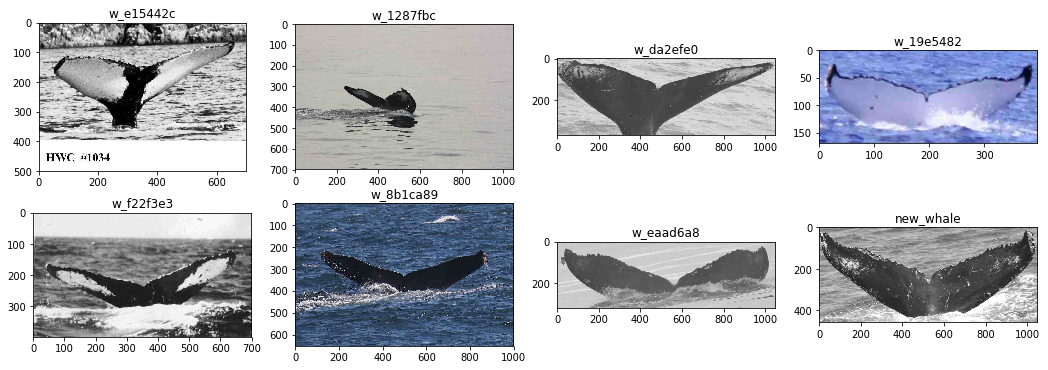

In [7]:
make_plot_whales(list(df_train.values)[:8])

In [8]:
def create_images(path):
    image = cv2.imread(path, 0)
    image = cv2.resize(image, (128, 128)) 
    images = [image]
    images.append(imutils.rotate(image, angle=random.randint(-45, 45)))
    edgeMap = imutils.auto_canny(image)
    edgeMap *= 50
    images.append(image - edgeMap)

    return images
    
def transformed_images(whale):
    images = create_images(TRAIN_IMAGES + whale[0])
    fig, axes = plt.subplots(1, int(len(images)))
    fig.set_size_inches(18, 6)

    for index, ax in enumerate(axes):
        image = images[index]
        im = ax.imshow(image, cmap = 'gray')
        ax.set_title(whale[1])

    plt.show()
    

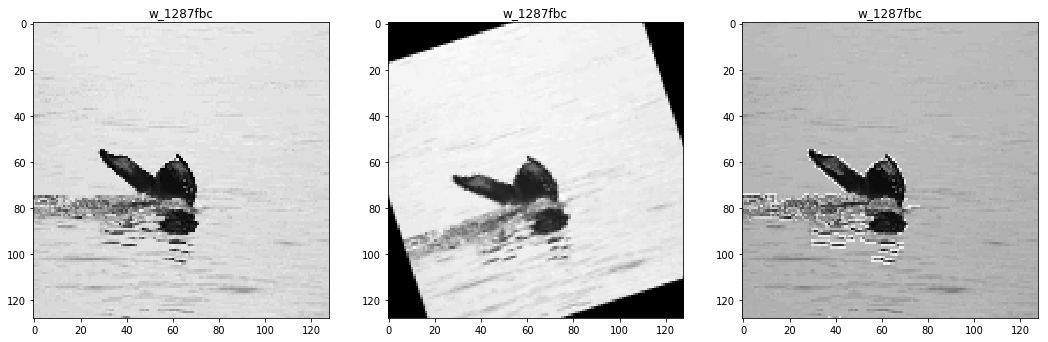

In [9]:
transformed_images(list(df_train.values)[1])

#### Train data 

In [10]:
train_images = []

train_labels_index = []
labels_names = list(df_train.Id.unique())          

i = 0 
for image_path, whale_id in df_train.values:

    #read image
    images = create_images(TRAIN_IMAGES + image_path) 
    train_images += images
   
    # get index for one hot vector 
    j = labels_names.index(whale_id)
    for image in images:
        train_labels_index.append(j)

# cast to right type for cnn
train_images = np.asarray(train_images, dtype=np.float32)
train_labels_index = np.asarray(train_labels_index, dtype=np.int32)


In [11]:
print(train_images.shape)
print(np.max(train_labels_index.shape))

(29550, 128, 128)
29550


In [12]:
print(type(train_images[0][0][0]))

<class 'numpy.float32'>


#### test data 

In [19]:
test_images = []
for image_path, _ in df_test.values:
    #read image
#     image = cv2.imread(TEST_IMAGES + image_path, 0)

    #crop image to 28 X 28:
    images = create_images(TEST_IMAGES + image_path) 
    test_images.append(images[0])
    
test_images = np.asarray(test_images, dtype=np.float32)

In [20]:
print(test_images.shape)

(15610, 128, 128)


## Use a CNN and train it using tensorflow

In [13]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features["x"], [-1, 128, 128, 1])

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
            inputs=input_layer,
            filters=32,
            kernel_size=[11, 11],
            padding="same",
            activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[5, 5], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[5, 5], strides=2)
    
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
            inputs=pool2,
            filters=128,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
    
    
    pool2 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[5, 5], strides=2)

    
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 128*13*13])
    dense = tf.layers.dense(inputs=pool2_flat, units=4251, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
            inputs=dense, rate=0.2, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=4251)
    
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=4251)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
                loss=loss,
                global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
            "accuracy": tf.metrics.accuracy(
                    labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [14]:
# Create the Estimator
whale_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./tensorflow_logs/whale_challange_38_preprocessing")

# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=1000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_log_step_count_steps': 100, '_session_config': None, '_task_id': 0, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_save_summary_steps': 100, '_model_dir': './tensorflow_logs/whale_challange_38_preprocessing', '_tf_random_seed': None, '_service': None, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f9903bfb470>, '_task_type': 'worker'}


In [15]:
#train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_images},
    y=train_labels_index,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

whale_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./tensorflow_logs/whale_challange_38_preprocessing/model.ckpt.
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
INFO:tensorflow:loss = 68.86117, step = 1
INFO:tensorflow:global_step/sec: 7.06328
INFO:tensorflow:loss = 7.8270507, step = 101 (14.158 sec)
INFO:tensorflow:global_step/sec: 7.08907
INFO:tensorflow:loss = 7.88673, step = 201 (14.106 sec)
INFO:tensorflow:global_step/sec: 7.09251
INFO:tensorflow:loss = 6.7197967, step = 301 (14.099 sec)
INFO:tensorflow:global_step/sec: 7.09704
INFO:tensorflow:loss = 6.830268, step = 401 (14.090 sec)
INFO:tensorflow:global_step/sec: 7.06413
INFO:tensorflow:loss = 6.883986, step = 501 (14.156 sec)
INFO:tensorflow:global_step/sec: 7.00276
INFO:tensorflow:loss = 6.942544, step = 601 (14.280 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:global_step/sec: 7.00816
INFO:tensorflow:loss = 0.44208503, step = 5401 (14.270 sec)
INFO:tensorflow:global_step/sec: 7.1407
INFO:tensorflow:loss = 0.12752348, step = 5501 (14.003 sec)
INFO:tensorflow:global_step/sec: 7.1304
INFO:tensorflow:loss = 0.22697824, step = 5601 (14.025 sec)
INFO:tensorflow:global_step/sec: 7.14717
INFO:tensorflow:loss = 0.524995, step = 5701 (13.991 sec)
INFO:tensorflow:global_step/sec: 7.12958
INFO:tensorflow:loss = 0.47389954, step = 5801 (14.027 sec)
INFO:tensorflow:global_step/sec: 7.13975
INFO:tensorflow:loss = 0.6801803, step = 5901 (14.006 sec)
INFO:tensorflow:global_step/sec: 7.13564
INFO:tensorflow:probabilities = [[0.         0.00000004 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00000197 0.   

INFO:tensorflow:global_step/sec: 7.14199
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00000001 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (140.025 sec)
INFO:tensorflow:loss = 0.29700854, step = 11001 (14.003 sec)
INFO:tensorflow:global_step/sec: 7.13518
INFO:tensorflow:loss = 0.3805999, step = 11101 (14.015 sec)
INFO:tensorflow:global_step/sec: 7.14768
INFO:tensorflow:loss = 0.192266, step = 11201 (13.990 sec)
INFO:tensorflow:global_step/sec: 7.13864
INFO:tensorflow:loss = 0.3526581, step = 11301 (14.008 sec)
INFO:tensorflow:global_step/sec: 7.15093
INFO:tensorflow:loss = 0.47781357, step = 11401 (13.984 sec)
INFO

KeyboardInterrupt: 

In [125]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

<img src="./images/cnn_3.png">
<img src="./images/cnn.png" style="height:400px">

###### LOGS 
1. first cnn with all labels and just in a two layerd cnn
2. same CNN with no new whale labels, chaned dense layer [place 35 on kaggle]
3. reshape 28 X 28 to 128 X 128 
4. Extra layers now 27 on kaggle
5. preprocessing images


# Predict test labels

In [21]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {"x": test_images},
    num_epochs = 1,
    shuffle=False)
prediction = whale_classifier.predict(input_fn = predict_input_fn)

In [22]:
prediction_list = list(prediction)

INFO:tensorflow:Restoring parameters from ./tensorflow_logs/whale_challange_38_preprocessing/model.ckpt-12744


In [23]:
prediction_list = np.array(prediction_list)

In [24]:
prediction_list[1]

{'classes': 3271,
 'probabilities': array([2.59850104e-17, 2.66509766e-11, 1.42926553e-16, ...,
        1.08185176e-13, 2.67994639e-15, 3.63042035e-13], dtype=float32)}

## Plot whales

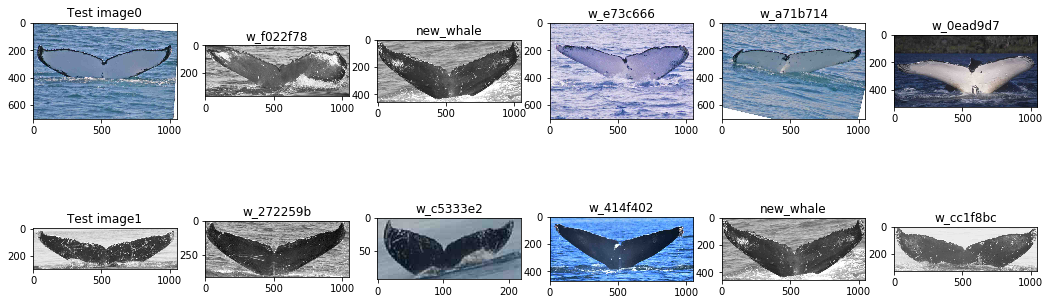

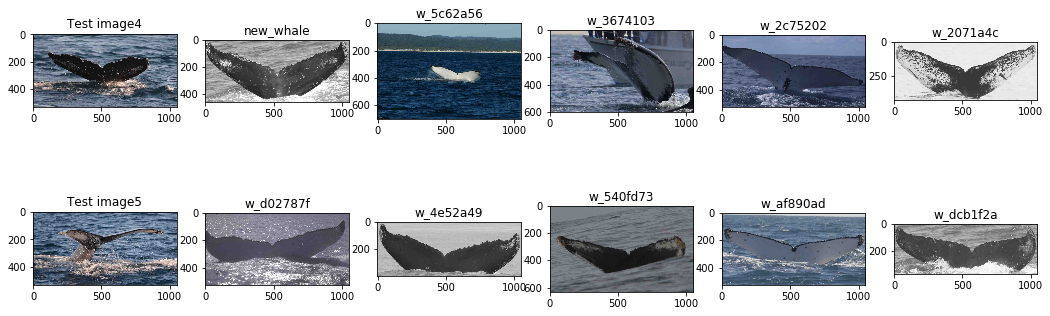

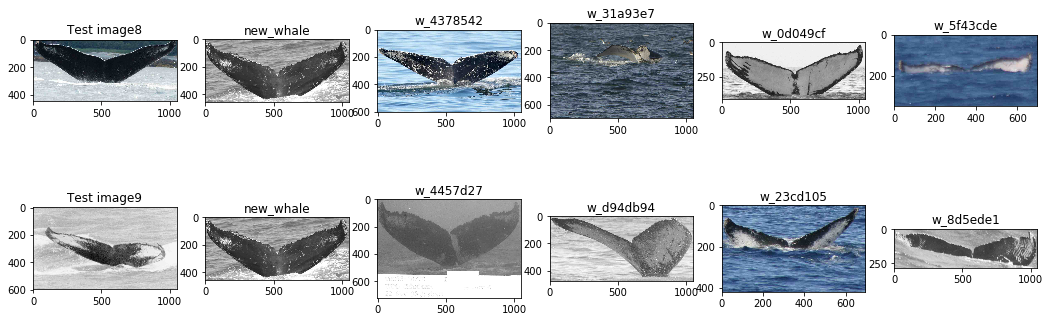

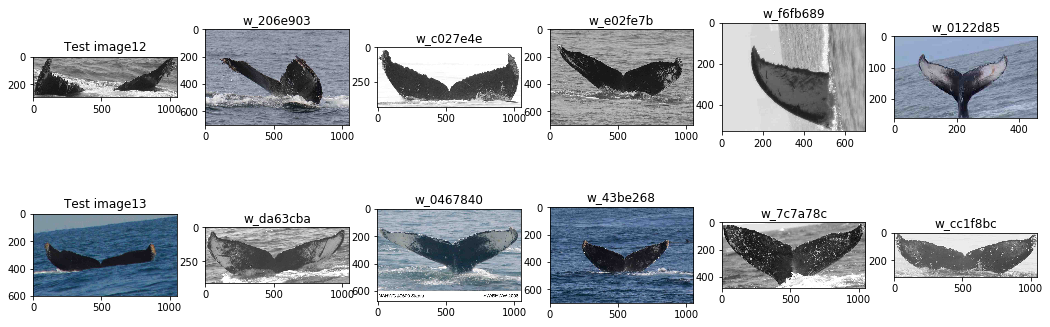

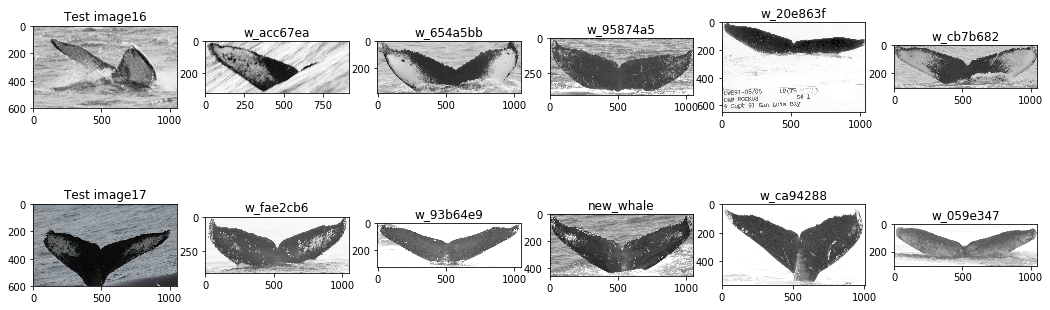

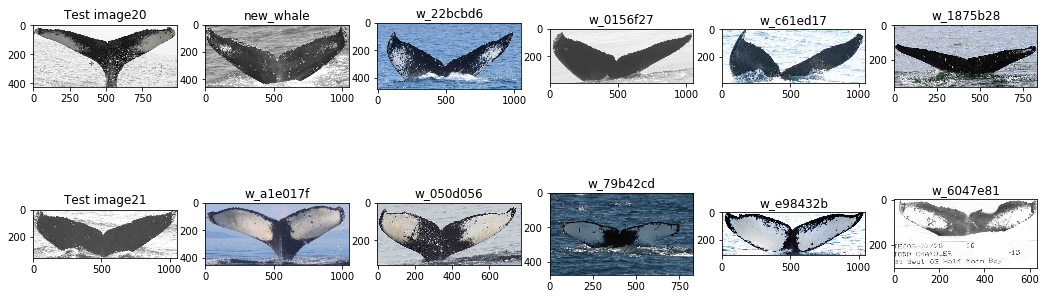

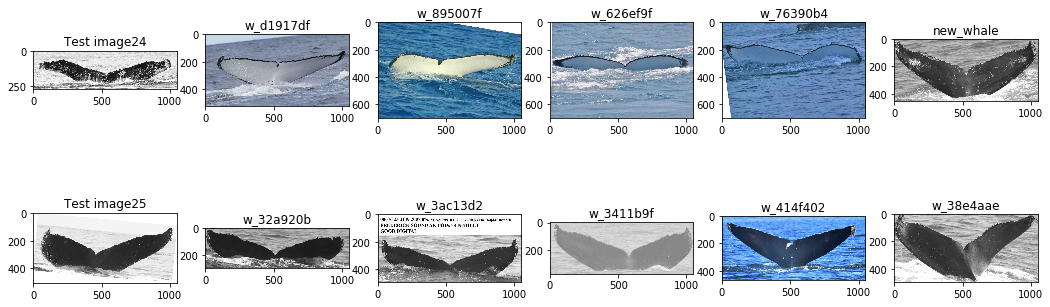

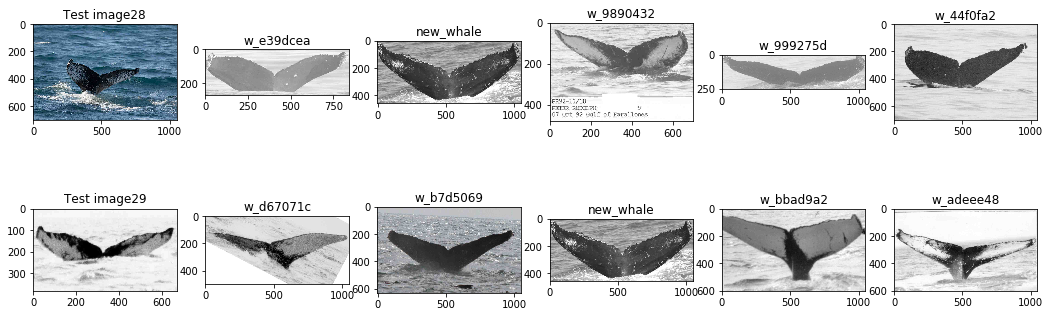

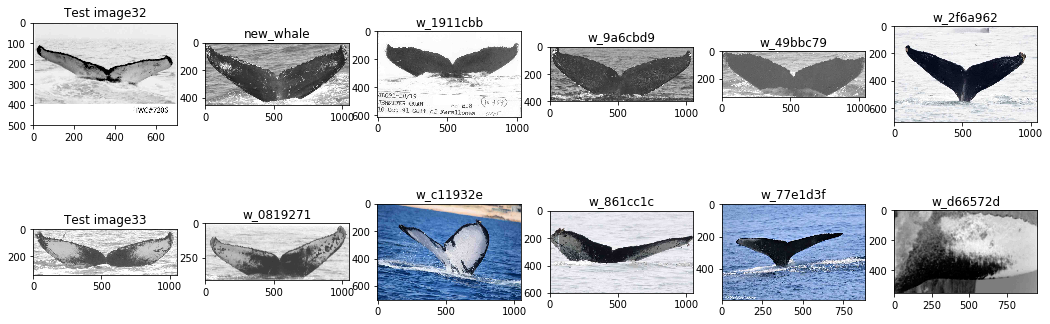

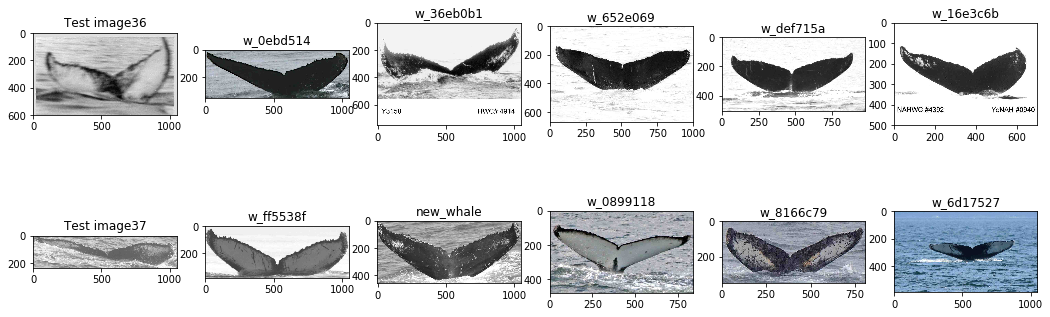

In [25]:
import heapq
import time

for i in range(0, 10):
    plot_images = []
    for j, prediction in enumerate(prediction_list[i*4 + i : i*4 + i +2]):
        idx = i*4 + j
        plot_images.append([df_test.Image.values[idx], "Test image" + str(idx)])
        for label in heapq.nlargest(5, prediction['probabilities']):
            prediction_class = list(prediction['probabilities']).index(label)
            df_whale = df_train.loc[df_train.Id == df_train.Id.unique()[prediction_class]]
            plot_images.append([df_whale.Image.values[0], df_whale.Id.values[0]])
    make_plot_whales(plot_images)




# Write to csv for submission kaggle

In [26]:
start_time = time.time()

whales_prediction = []
for idx, prediction in enumerate(list(prediction_list)):
    ids = []
    for label in heapq.nlargest(5, prediction['probabilities']):
        prediction_class = list(prediction['probabilities']).index(label)
        df_whale = df_train.loc[df_train.Id == df_train.Id.unique()[prediction_class]]
        ids.append(df_whale.Id.values[0])
    whales_prediction.append({'Image': df_test.Image.values[idx], 'Id': " ".join(ids)})
print("creating data_set took: {}".format(time.time() - start_time))

creating data_set took: 105.91305446624756


In [451]:
prediction_df = pd.DataFrame.from_dict(whales_prediction)

In [452]:
prediction_df.head(10)

,Id,Image
0,new_whale w_7a53e0c w_4e1f7bd w_7ab1759 w_4ce0510,00029b3a.jpg
1,w_0beef28 w_7ba4b5a w_9771603 w_773509f new_whale,0003c693.jpg
2,w_fba3bde w_6c803bf w_0e737d0 new_whale w_a59905f,000bc353.jpg
3,w_2ac069f w_43be268 new_whale w_0c70bc3 w_18eee6e,0010a672.jpg
4,new_whale w_5be8e63 w_8464638 w_2b939eb w_6c803bf,00119c3f.jpg
5,new_whale w_329e594 w_7554f44 w_98baff9 w_efd3f81,001259cc.jpg
6,w_dfbfe10 new_whale w_9b401eb w_89e159a w_3ee8570,0015f9b4.jpg
7,new_whale w_13c6b6b w_0ad6137 w_e7a238b w_43be268,0018c4ba.jpg
8,new_whale w_0beef28 w_2fe43c7 w_62f804d w_654a5bb,001bf484.jpg
9,new_whale w_993dbe8 w_1eafe46 w_d0157fd w_ab4cae2,002d8d81.jpg


In [453]:
prediction_df.to_csv('./data/prediction.csv', columns=["Image", "Id"], index=False)